### Cepstral analysis example code

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display

In [2]:
# Import pyceps implementation
from pyceps.core import rceps, cepsf0, cepsenv
from pyceps.utils import upsample

In [3]:
# Import pre-trained CREPE model for comparison
import crepe

### 0. Preparation
#### 0.1 Load audio file

* speech audio signal from RAVDESS dataset: https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio
* guitar audio signal from GuitarSet dataset: https://github.com/marl/GuitarSet

In [4]:
speech, sr = librosa.load('/Users/hwang9u/h9Speech/dataset/ravdess/Actor_03/03-01-01-01-01-01-03.wav', offset=0.8, duration=2)
guitar, sr = librosa.load('/Users/hwang9u/h9music/dataset/GuitarSet/audio_mono-mic/05_SS2-88-F_solo_mic.wav')

#### 0.2 STFT
* ```win_length```: 1024(0.046ms)
* ```n_fft```: 2048(0.092ms) (for high resolution of FFT)
* ```hop_length```: 1102(5ms)

In [5]:
hop_length = int(sr*0.05); print('hop_length:', hop_length)
D_speech = librosa.amplitude_to_db(np.abs(librosa.stft(speech, n_fft=2048, win_length=2048, hop_length= hop_length, center=True)))
D_guitar = librosa.amplitude_to_db(np.abs(librosa.stft(guitar, n_fft=2048, win_length=2048, hop_length= hop_length, center=True)))

print(D_speech.shape, D_guitar.shape)

hop_length: 1102
(1025, 41) (1025, 873)


### 1. F0(pitch) Estimation


#### 1.1 Example

In [6]:
f0_speech, p_ind_speech = cepsf0(D_speech, sr=sr, fmax=400., remove_outliers=True)
f0_guitar, p_ind_guitar = cepsf0(D_guitar, sr=sr, fmax=1000., remove_outliers=True)

Search F0 in the range below 393.75 [Hz] / quefrency: 0.0025397(55)
Search F0 in the range below 958.70 [Hz] / quefrency: 0.0010431(22)


In [7]:
def plot_f0(D, f0, ax, hop_length, title=''):
    librosa.display.specshow(D, x_axis='time', y_axis='log', hop_length=hop_length, cmap = 'magma', ax = ax)    
    ax.plot(np.arange(D.shape[1])/sr * hop_length, f0, c = 'cyan')
    ax.set_title(title)
    # ax.legend(['F0'])


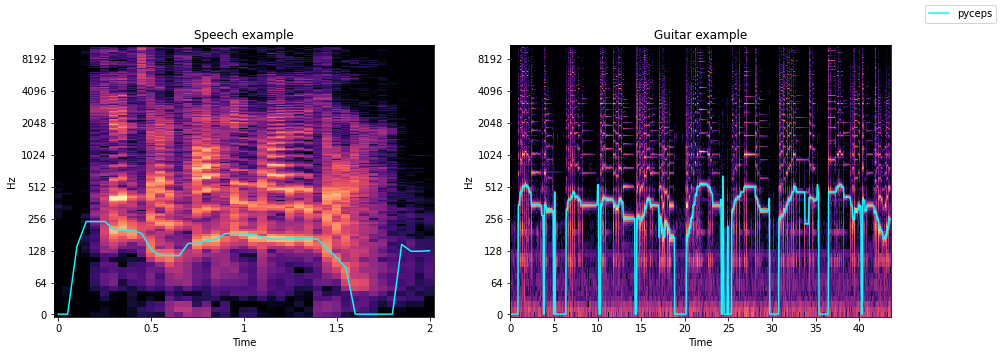

In [8]:
fig, axes = plt.subplots(1, 2, figsize = (15,5))
plot_f0(D_speech, f0_speech, hop_length=hop_length, ax=axes[0], title='Speech example')
plot_f0(D_guitar, f0_guitar, hop_length=hop_length, ax=axes[1], title='Guitar example')
fig.legend( labels = ['pyceps'])
fig.savefig('./examples/estimated_f0.jpg')

#### 1.2 Comparison with CREPE

In [9]:
def crepe_f0(sig):
    audio = sig* (2**15 -1) # same foramt as scipy.wavfile
    time, frequency, confidence, activation = crepe.predict(audio, sr, viterbi=True)
    return time, frequency

In [10]:
t_s, f0_speech_c = crepe_f0(speech)
t_g, f0_guitar_c = crepe_f0(guitar) # slower than cepstral method

137/137 [==============================] - 75s 547ms/step


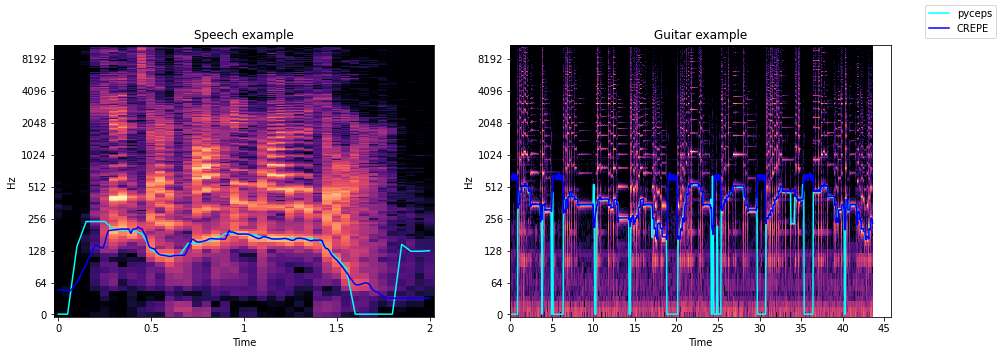

In [11]:
## Comparison
fig, axes = plt.subplots(1, 2, figsize = (15,5))
plot_f0(D_speech, f0_speech, hop_length=hop_length, ax=axes[0], title='Speech example')
spec = axes[0].plot( t_s , f0_speech_c, c = 'blue')

plot_f0(D_guitar, f0_guitar, hop_length=hop_length, ax=axes[1], title='Guitar example')
axes[1].plot( t_g , f0_guitar_c, c = 'blue')
fig.legend( labels = ['pyceps', 'CREPE'])
fig.savefig('./examples/with_crepe.jpg')


### 2. Envelope
#### 2.1 Example


In [12]:
lift = 30
q, C_speech =rceps(D_speech, sr=sr, qmin_ind=0) ; q, C_guitar =rceps(D_guitar, sr=sr, qmin_ind=0)
E_speech = cepsenv(C_speech, lift_th=lift) ; E_guitar = cepsenv(C_guitar, lift_th=lift)

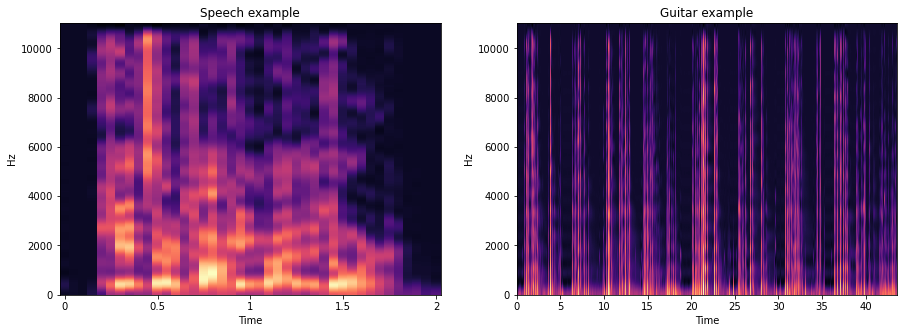

In [13]:
fig, axes = plt.subplots(1,2, figsize = (15,5))
librosa.display.specshow(E_speech, x_axis='time', y_axis='linear', hop_length=hop_length, cmap = 'magma', ax = axes[0])    
librosa.display.specshow(E_guitar, x_axis='time', y_axis='linear', hop_length=hop_length, cmap = 'magma', ax = axes[1])   
axes[0].set_title('Speech example') 
axes[1].set_title('Guitar example') 
fig.savefig('./examples/cepstrally_smoothed.jpg')

In [14]:
def plot_envelope(logM, envelope, ax, title, lift = 30):
    ax.plot(logM)
    ax.plot(envelope)
    ax.set_title(title)
    ax.set_xlabel('k')
    ax.set_ylabel('magnitude (dB)')
    ax.legend(['log magnitude', 'lift = {}'.format(lift)])

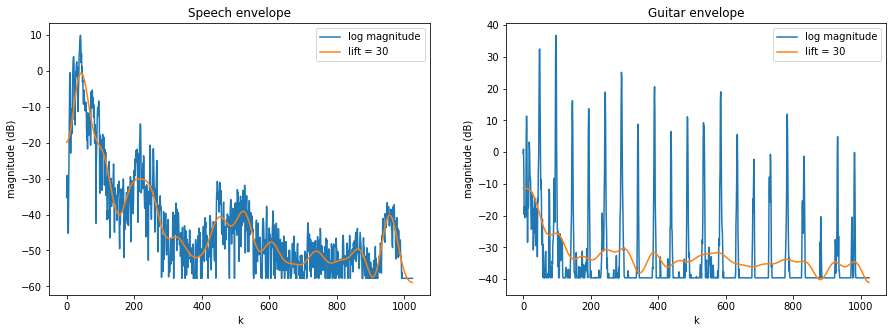

In [15]:
t = 30
fig, axes = plt.subplots(1,2, figsize = (15,5))
plot_envelope(D_speech[:,t], E_speech[:,t], ax=axes[0], title='Speech envelope', lift=30)
plot_envelope(D_guitar[:,t], E_guitar[:,t], ax=axes[1], title='Guitar envelope', lift=30)
fig.savefig('./examples/estimated_envelope.jpg')